# Skeleton plot that shows the arborization of all 6 clusters by Color
Steps in this file:
- Import skeleton, using 2d skeletons segments (kind of buggy)
- Import partition data for full connectome
- Import synapse location data
- Process dataframes so that synapse location and cluster are on the same dataframe
- Assign colors with a dictionary and then map
- Plot segments and synapses with legend

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bokeh
import bokeh.palettes
from bokeh.plotting import figure, output_notebook, show, output_file, gridplot
from bokeh.io import export_svg, export_png
from bokeh.models import Legend, LegendItem
import os
from neuprint import Client


auth_token_file = open("flybrain.auth.txt", 'r')
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:v1.2.1', token=auth_token)
except:
    np_client = None

output_notebook()

Loading BokehJS ...

In [2]:
from neuprint import fetch_synapse_connections, SynapseCriteria as SC, merge_neuron_properties, fetch_neurons

In [3]:
# Create skeleton for later usage (inspired from Prof G.'s notebook ovi_specs_sandbox.ipynb)
# body Ids of oviINs
ovi_r = 423101189
ovi_l = 485934965
ovis = [ovi_r, ovi_l]

# cretae skeleton for both oviINs
skeletons = []


s = np_client.fetch_skeleton(ovi_r, format='pandas')
s['bodyId'] = ovi_r
s['color'] = bokeh.palettes.Greys[3][1]
skeletons.append(s)

skeletons = pd.concat(skeletons, ignore_index=True)

In [4]:
# Join parent nodes
segments = skeletons.merge(skeletons, left_on=['bodyId', 'link'], right_on=['bodyId', 'rowId'], suffixes=['_child', '_parent'])

In [5]:
# import full connectome data and location data
ovi_node_df  = pd.read_csv('/Users/rweberla/Downloads/0-0_98765.txt', header=None, sep=' ', names=['id', "0.0"])

# Import synapse location data for pre-synaptic sites
ovi_pre_syns = pd.read_csv('ovi_pre_syns.csv', index_col=0)


In [6]:
ovi_pre_syns

,bodyId_pre,bodyId_post,roi_pre,roi_post,x_pre,y_pre,z_pre,x_post,y_post,z_post,confidence_pre,confidence_post,type_pre,type_post
0,989228019,423101189,CRE(R),CRE(R),22857,34611,17485,22825,34624,17464,0.998,0.633171,FB5V,NaN
1,988909130,423101189,CRE(R),CRE(R),19523,31096,21707,19509,31112,21693,0.969,0.528840,FB5V,NaN
2,988567837,423101189,LAL(R),LAL(R),23100,27659,23824,23074,27659,23801,0.970,0.459446,FB4G,NaN
3,987842109,423101189,SMP(R),SMP(R),19041,33090,14598,19047,33072,14598,0.973,0.974019,NaN,NaN
4,987273073,423101189,CRE(R),CRE(R),19347,27826,15348,19351,27806,15376,0.943,0.595921,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21619,1006928515,423101189,IB,IB,22664,14840,19749,22651,14823,19757,0.994,0.865103,CL300,NaN
21620,1005952640,423101189,IB,IB,21998,15625,18990,22007,15603,18991,0.996,0.929040,IB058,NaN
21621,1005952640,423101189,IB,IB,22998,15275,23049,23014,15272,23060,0.835,0.780000,IB058,NaN
21622,1005952640,423101189,IB,IB,23034,15380,23131,23048,15364,23146,0.986,0.905853,IB058,NaN


In [7]:
# edit dataframes for easy merging
ovi_clusters = ovi_node_df[['id', '0.0']].copy()
ovi_locs = ovi_pre_syns[['bodyId_pre', 'x_post', 'y_post', 'z_post']].copy()

# merge synapse data onto cluster data
ovi_plotting = ovi_clusters.merge(ovi_locs, left_on='id', right_on='bodyId_pre').drop(columns='bodyId_pre')
ovi_plotting

,id,0.0,x_post,y_post,z_post
0,1003215282,1,24282,16879,21874
1,1005952640,2,22007,15603,18991
2,1005952640,2,23014,15272,23060
3,1005952640,2,23048,15364,23146
4,1006928515,3,22651,14823,19757
...,...,...,...,...,...
18777,987117151,2,17185,30699,23308
18778,987273073,6,19351,27806,15376
18779,988567837,5,23074,27659,23801
18780,988909130,5,19509,31112,21693


In [8]:
# Create color dictionary where each number in column 0.0 is assigned a color
#colors = ['', '#', '#e7cf57', '#ff6a88', '#', '#', '#9fad2b']
color_dict = {1: '#4e90d3', 2: '#9467bd', 3: '#e7cf57', 4: '#ff6a88', 5: '#5cc9ff', 6: '#3a9f82', 7: '#9fad2b'}

# Merge color dictionary onto dataframe
ovi_plotting['color'] = ovi_plotting['0.0'].map(color_dict)
ovi_plotting

,id,0.0,x_post,y_post,z_post,color
0,1003215282,1,24282,16879,21874,#4e90d3
1,1005952640,2,22007,15603,18991,#9467bd
2,1005952640,2,23014,15272,23060,#9467bd
3,1005952640,2,23048,15364,23146,#9467bd
4,1006928515,3,22651,14823,19757,#e7cf57
...,...,...,...,...,...,...
18777,987117151,2,17185,30699,23308,#9467bd
18778,987273073,6,19351,27806,15376,#3a9f82
18779,988567837,5,23074,27659,23801,#5cc9ff
18780,988909130,5,19509,31112,21693,#5cc9ff


KeyboardInterrupt: 

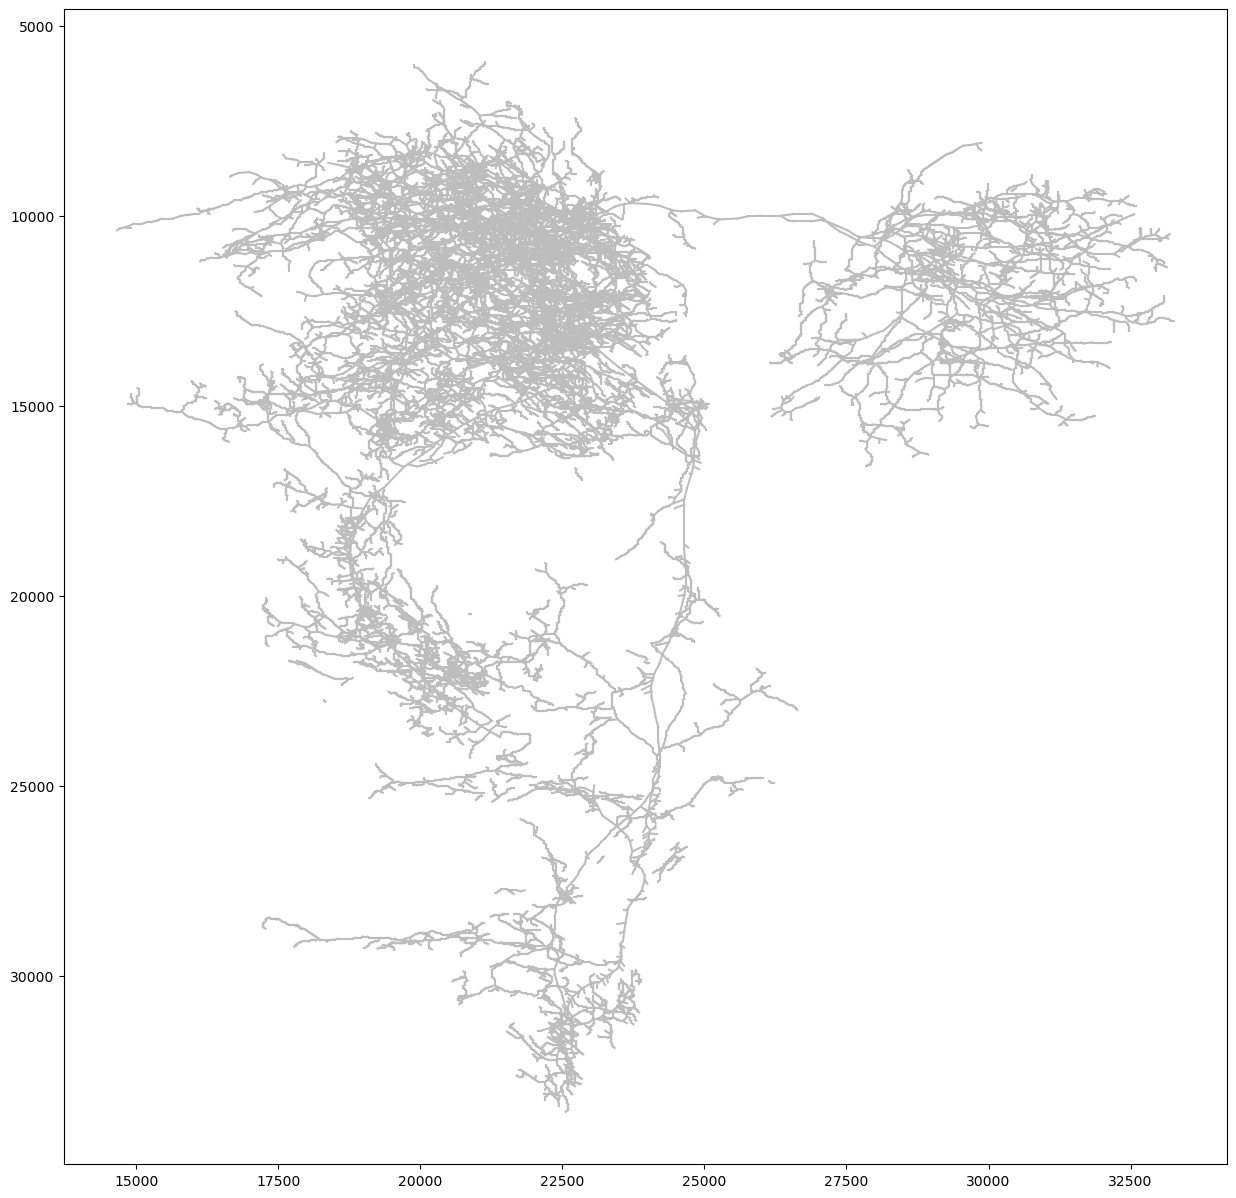

In [9]:
# Plot the skeleton and clusters with labels
fig, ax = plt.subplots(figsize=(15, 15))
ax.invert_yaxis()  # Flip the y-axis

# Plot the skeleton (2D)
for index, row in segments.iterrows():
    ax.plot([row['x_child'], row['x_parent']], [row['z_child'], row['z_parent']], color=row['color_child'], zorder=1)

# Drop axes 

# plot clusters with legend of clusters corresponding to colors
ax.scatter(ovi_plotting['x_post'], ovi_plotting['z_post'], c=ovi_plotting['color'], s=2, zorder=2)
ax.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.3, 1))

plt.axis('off')


## By cluster

In [ ]:
# Plot the skeleton plot so it just shows one cluster at a time, should be 7 plots
clusters = [1, 2, 3, 4, 5, 6, 7]
def cluster_nt(df, cluster_list):
    fig, ax = plt.subplots(3,3,figsize=(18, 18))
    for i, cluster in enumerate(cluster_list):
        ax[int(i /3), i % 3].invert_yaxis()  # Flip the y-axis 
        # drop y axis
        ax[int(i / 3), i % 3].set_yticks([])
        ax[int(i / 3), i % 3].set_xticks([])
        df_x = df[df['0.0']==cluster]
        for index, row in segments.iterrows():
            ax[int(i / 3), i % 3].plot([row['x_child'], row['x_parent']], [row['z_child'], row['z_parent']], c=row['color_child'], linewidth= 0.5, zorder=1)
        # Plot skeleton 6 times, each time with a different cluster
        ax[int(i / 3), i % 3].scatter(df_x['x_post'], df_x['z_post'], color=df_x["color"], s=1, zorder=10)
        # Set title for the subplot
        ax[int(i / 3), i % 3].set_title('Cluster ' + str(cluster))



## By cluster using bokeh

# Skeleton plot for celltype breakdown

In [ ]:
ovi_cell  = pd.read_csv('oviIN_celltype/oviIN_combined/full/preprocessed-v1.2.1/preprocessed_nodes.csv')
ovi_cell

,Unnamed: 0,celltype,key,0.75,0.05,0.1,0.25,0.5,1.0,0.0
0,0,NaN,1,1,1,1,1,1,1,1
1,1,5-HTPMPD01,2,2,1,1,2,2,2,1
2,2,5-HTPMPV01,3,3,2,2,3,3,3,2
3,3,5-HTPMPV03,4,4,2,3,3,4,4,2
4,4,ALIN3,5,5,3,4,4,5,5,3
...,...,...,...,...,...,...,...,...,...,...
1458,1458,pC1d,1459,439,2,2,70,317,588,2
1459,1459,pC1e,1460,489,2,2,3,349,555,2
1460,1460,v2LN37,1461,511,3,10,17,188,319,3
1461,1461,vpoDN,1462,114,1,1,59,40,92,1


In [ ]:
# edit dataframes for easy merging
ovi_type_clusters = ovi_cell[['celltype', '0.0']].copy()
ovi_locs_type = ovi_pre_syns[['type_pre', 'x_pre', 'y_pre', 'z_pre']].copy()

# Drop the NaN value in type clusters
ovi_type_clusters = ovi_type_clusters.dropna()

ovi_type_clusters

,celltype,0.0
1,5-HTPMPD01,1
2,5-HTPMPV01,2
3,5-HTPMPV03,2
4,ALIN3,3
5,AOTU003,4
...,...,...
1458,pC1d,2
1459,pC1e,2
1460,v2LN37,3
1461,vpoDN,1


In [ ]:
# Count clusters
ovi_type_clusters['0.0'].unique()

array([1, 2, 3, 4, 5, 6])

In [ ]:
# Merge synapse data onto cluster data
ovi_plotting_type = ovi_type_clusters.merge(ovi_locs_type, left_on='celltype', right_on='type_pre').drop(columns='type_pre')
ovi_plotting_type

,celltype,0.0,x_pre,y_pre,z_pre
0,5-HTPMPD01,1,21089,26095,7633
1,5-HTPMPD01,1,19883,31703,9300
2,5-HTPMPD01,1,21957,27833,8998
3,5-HTPMPV01,2,20615,19829,11336
4,5-HTPMPV01,2,19899,20712,12149
...,...,...,...,...,...
25552,vpoDN,1,21269,31699,9148
25553,vpoEN,2,22124,21278,24893
25554,vpoEN,2,22081,21270,24898
25555,vpoEN,2,22190,21296,24976


In [ ]:
# Create color dictionary where each number in column 0.0 is assigned a color
color_dict = {1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5: 'pink', 6: 'orange'}

# Merge color dictionary onto dataframe
ovi_plotting_type['color'] = ovi_plotting_type['0.0'].map(color_dict)
ovi_plotting_type

,celltype,0.0,x_pre,y_pre,z_pre,color
0,5-HTPMPD01,1,21089,26095,7633,red
1,5-HTPMPD01,1,19883,31703,9300,red
2,5-HTPMPD01,1,21957,27833,8998,red
3,5-HTPMPV01,2,20615,19829,11336,blue
4,5-HTPMPV01,2,19899,20712,12149,blue
...,...,...,...,...,...,...
25552,vpoDN,1,21269,31699,9148,red
25553,vpoEN,2,22124,21278,24893,blue
25554,vpoEN,2,22081,21270,24898,blue
25555,vpoEN,2,22190,21296,24976,blue


Text(0.5, 1.0, 'OviINs with cell types clustered')

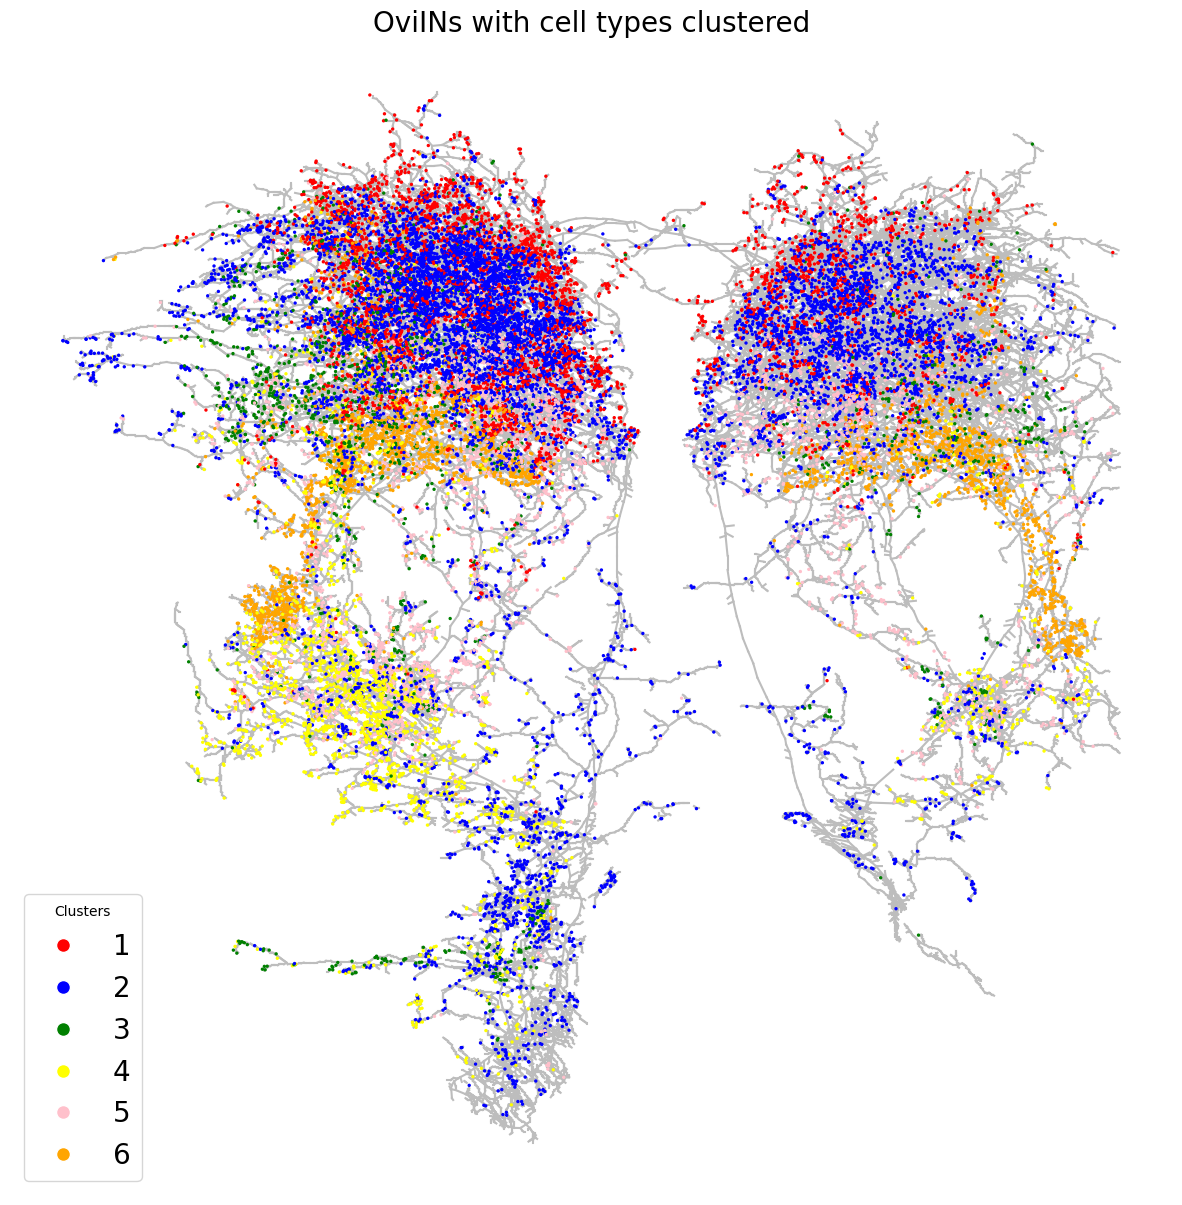

In [ ]:
# Plot the skeleton and clusters with labels
fig, ax = plt.subplots(figsize=(15, 15))
ax.invert_yaxis()  # Flip the y-axis

# Plot the skeleton (2D)
for index, row in segments.iterrows():
    ax.plot([row['x_child'], row['x_parent']], [row['z_child'], row['z_parent']], color=row['color_child'], zorder=1)

# Drop axes 

# plot clusters with legend of clusters corresponding to colors
ax.scatter(ovi_plotting_type['x_pre'], ovi_plotting_type['z_pre'], c=ovi_plotting_type['color'], s=2, zorder=2)
ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='1'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='2'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='3'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='4'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='pink', markersize=10, label='5'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='6')], title='Clusters',fontsize="20", loc='lower left')
plt.axis('off')
plt.title('OviINs with cell types clustered', fontsize=20)


In [ ]:
ovi_plotting_type[ovi_plotting_type['celltype']=='FS1A']


,celltype,0.0,x_pre,y_pre,z_pre,color
3766,FS1A,6,19832,26702,15404,orange
3767,FS1A,6,20845,26499,15613,orange
3768,FS1A,6,20373,26632,15491,orange
3769,FS1A,6,20897,26459,15609,orange
3770,FS1A,6,19506,26715,15912,orange
...,...,...,...,...,...,...
5350,FS1A,6,31949,26913,15156,orange
5351,FS1A,6,31442,26585,15559,orange
5352,FS1A,6,30865,27005,14987,orange
5353,FS1A,6,31281,26775,16116,orange
